In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import io
import imageio
from tensorflow.keras.preprocessing import image_dataset_from_directory

import PIL
from PIL import ImageFont, ImageDraw, Image

In [45]:
dir_train = 'A://workspace//datasets//tiny_imagenet//train.parquet'
dir_valid = 'A://workspace//datasets//tiny_imagenet//valid.parquet'

In [43]:
train_dataset = pd.read_parquet(dir_train, engine='pyarrow')
train_dataset.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [46]:
valid_dataset = pd.read_parquet(dir_valid, engine='pyarrow')
valid_dataset.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [5]:
%%time
train_dataset['byte_image'] = train_dataset['image'].apply(lambda x: np.array(Image.open(io.BytesIO(x['bytes']))))
train_dataset.head()

CPU times: total: 7.38 s
Wall time: 7.42 s


,image,label,byte_image
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[255, 136, 193], [255, 138, 192], [249, 146,..."
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[20, 33, 7], [19, 32, 6], [23, 31, 10], [28,..."
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[120, 124, 127], [89, 93, 96], [80, 84, 87],..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[144, 170, 245], [121, 147, 221], [140, 166,..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,"[[[144, 145, 147], [141, 142, 144], [140, 140,..."


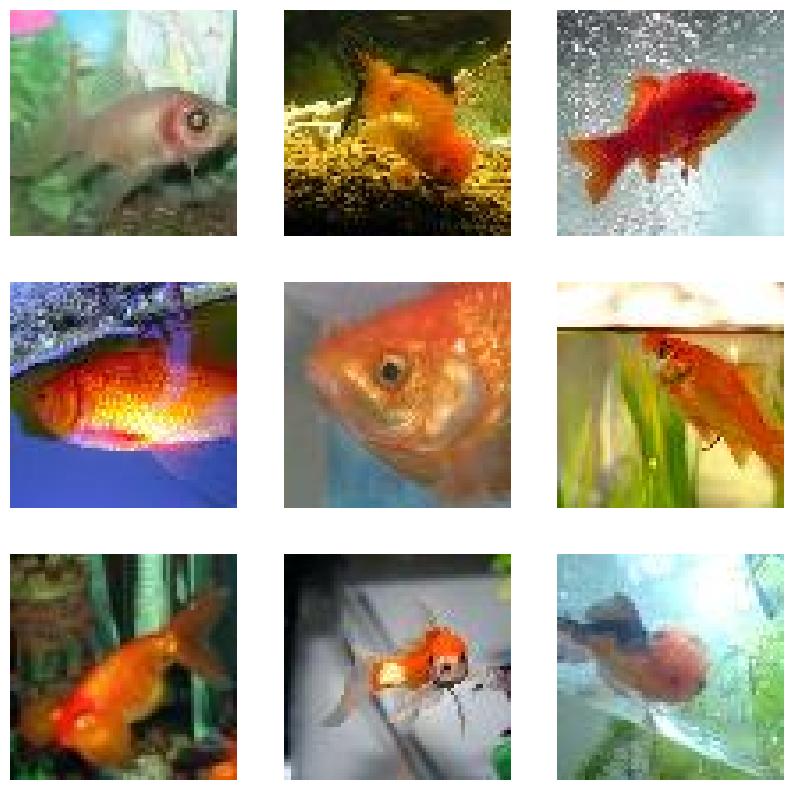

In [39]:
plt.figure(figsize=(10, 10))
for i, image in train_dataset['byte_image'][:9].items():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

In [47]:
train_dataset['label']

0          0
1          0
2          0
3          0
4          0
        ... 
99995    199
99996    199
99997    199
99998    199
99999    199
Name: label, Length: 100000, dtype: int64